# Deep Kernel Learning

In this notebook we demonstrate how GPJax can be used in conjunction with
[Flax](https://flax.readthedocs.io/en/latest/) to build deep kernel Gaussian
processes. Modelling data with discontinuities is a challenging task for regular
Gaussian process models. However, as shown in
<strong data-cite="wilson2016deep"></strong>, transforming the inputs to our
Gaussian process model's kernel through a neural network can offer a solution to this.

In [1]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from dataclasses import (
    dataclass,
    field,
)
from typing import Any

import flax
from flax import linen as nn
import jax
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
)
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox
from scipy.signal import sawtooth
from gpjax.base import static_field

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
    from gpjax.base import param_field
    import gpjax.kernels as jk
    from gpjax.kernels import DenseKernelComputation
    from gpjax.kernels.base import AbstractKernel
    from gpjax.kernels.computations import AbstractKernelComputation

key = jr.PRNGKey(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

## Dataset

As previously mentioned, deep kernels are particularly useful when the data has
discontinuities. To highlight this, we will use a sawtooth function as our data.

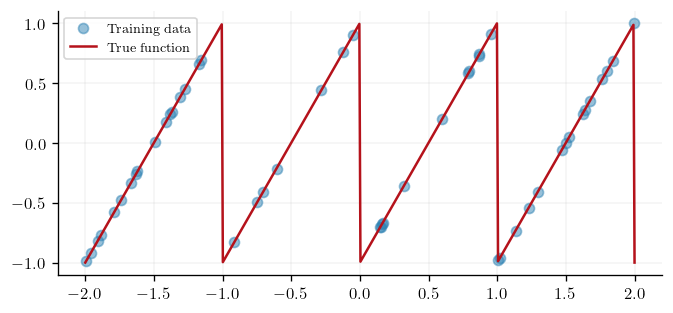

In [2]:
n = 50
noise = 1e-3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-2.0, maxval=2.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.asarray(sawtooth(2 * jnp.pi * x))
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-2.0, 2.0, 500).reshape(-1, 1)
ytest = f(xtest)

fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Training data", alpha=0.5)
ax.plot(xtest, ytest, label="True function")
ax.legend(loc="best")

## Deep kernels

### Details

Instead of applying a kernel $k(\cdot, \cdot')$ directly on some data, we seek to
apply a _feature map_ $\phi(\cdot)$ that projects the data to learn more meaningful
representations beforehand. In deep kernel learning, $\phi$ is a neural network
whose parameters are learned jointly with the GP model's hyperparameters. The
corresponding kernel is then computed by $k(\phi(\cdot), \phi(\cdot'))$. Here
$k(\cdot,\cdot')$ is referred to as the _base kernel_.

### Implementation

Although deep kernels are not currently supported natively in GPJax, defining one is
straightforward as we now demonstrate. Inheriting from the base `AbstractKernel`
in GPJax, we create the `DeepKernelFunction` object that allows the
user to supply the neural network and base kernel of their choice. Kernel matrices
are then computed using the regular `gram` and `cross_covariance` functions.

In [3]:
@dataclass
class DeepKernelFunction(AbstractKernel):
    base_kernel: AbstractKernel = None
    network: nn.Module = static_field(None)
    dummy_x: jax.Array = static_field(None)
    key: jr.PRNGKeyArray = static_field(jr.PRNGKey(123))
    nn_params: Any = field(init=False, repr=False)

    def __post_init__(self):
        if self.base_kernel is None:
            raise ValueError("base_kernel must be specified")
        if self.network is None:
            raise ValueError("network must be specified")
        self.nn_params = flax.core.unfreeze(self.network.init(key, self.dummy_x))

    def __call__(
        self, x: Float[Array, " D"], y: Float[Array, " D"]
    ) -> Float[Array, "1"]:
        state = self.network.init(self.key, x)
        xt = self.network.apply(state, x)
        yt = self.network.apply(state, y)
        return self.base_kernel(xt, yt)

/tmp/ipykernel_16196/2049055555.py:6: DeprecationWarning: jax.random.PRNGKeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  key: jr.PRNGKeyArray = static_field(jr.PRNGKey(123))


### Defining a network

With a deep kernel object created, we proceed to define a neural network. Here we
consider a small multi-layer perceptron with two linear hidden layers and ReLU
activation functions between the layers. The first hidden layer contains 64 units,
while the second layer contains 32 units. Finally, we'll make the output of our
network a three units wide. The corresponding kernel that we define will then be of
[ARD form](https://docs.jaxgaussianprocesses.com/examples/constructing_new_kernels/#active-dimensions)
to allow for different lengthscales in each dimension of the feature space.
Users may wish to design more intricate network structures for more complex tasks,
which functionality is supported well in Haiku.

In [35]:
feature_space_dim = 3


class Network(nn.Module):
    """A simple MLP."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=feature_space_dim)(x)
        return x


forward_linear = Network()

## Defining a model

Having characterised the feature extraction network, we move to define a Gaussian
process parameterised by this deep kernel. We consider a third-order Matérn base
kernel and assume a Gaussian likelihood.

In [36]:
base_kernel = gpx.kernels.Matern52(
    active_dims=list(range(feature_space_dim)),
    lengthscale=jnp.ones((feature_space_dim,)),
)
kernel = DeepKernelFunction(
    network=forward_linear, base_kernel=base_kernel, key=key, dummy_x=x
)
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=noise)
likelihood = likelihood.replace_trainable(obs_stddev=False)
posterior = prior * likelihood

### Optimisation

We train our model via maximum likelihood estimation of the marginal log-likelihood.
The parameters of our neural network are learned jointly with the model's
hyperparameter set.

With the inclusion of a neural network, we take this opportunity to highlight the
additional benefits gleaned from using
[Optax](https://optax.readthedocs.io/en/latest/) for optimisation. In particular, we
showcase the ability to use a learning rate scheduler that decays the optimiser's
learning rate throughout the inference. We decrease the learning rate according to a
half-cosine curve over 700 iterations, providing us with large step sizes early in
the optimisation procedure before approaching more conservative values, ensuring we
do not step too far. We also consider a linear warmup, where the learning rate is
increased from 0 to 1 over 50 steps to get a reasonable initial learning rate value.

  0%|          | 0/2000 [00:00<?, ?it/s]

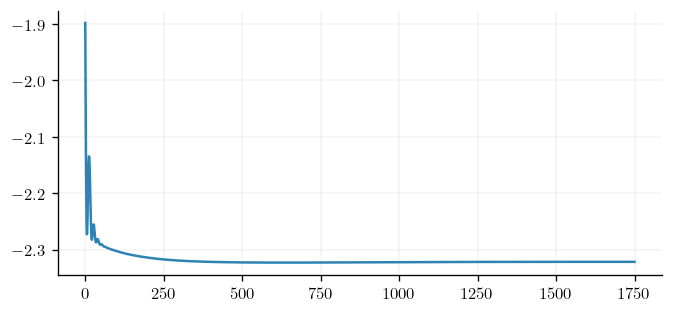

In [43]:
schedule = ox.warmup_cosine_decay_schedule(
    init_value=0.01,
    peak_value=0.1,
    warmup_steps=500,
    decay_steps=1900,
    end_value=0.001,
)

optimiser = ox.chain(
    ox.clip(1.0),
    #ox.adam(learning_rate=1e-2),
    ox.adamw(learning_rate=schedule),
)

opt_posterior, history = gpx.fit(
    model=posterior,
    objective=jax.jit(gpx.objectives.ConjugateMLL(negative=True)),
    train_data=D,
    optim=optimiser,
    num_iters=2000,
    key=key,
)

plt.plot(history[250:])

## Prediction

With a set of learned parameters, the only remaining task is to predict the output
of the model. We can do this by simply applying the model to a test data set.

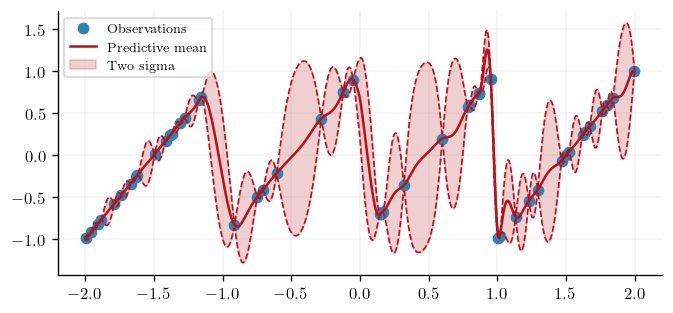

In [44]:
latent_dist = opt_posterior(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations", color=cols[0])
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    color=cols[1],
    label="Two sigma",
)
ax.plot(
    xtest,
    predictive_mean - 2 * predictive_std,
    color=cols[1],
    linestyle="--",
    linewidth=1,
)
ax.plot(
    xtest,
    predictive_mean + 2 * predictive_std,
    color=cols[1],
    linestyle="--",
    linewidth=1,
)
ax.legend()

## System configuration

In [8]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Pinder'

Author: Thomas Pinder

Last updated: Mon Dec 11 2023

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.17.2

flax      : 0.6.11
gpjax     : 0.8.0
jax       : 0.4.20
matplotlib: 3.8.1
optax     : 0.1.7

Watermark: 2.4.3

